In [1]:
import numpy as np
import matplotlib.pyplot as plt
from __future__ import print_function, division
%matplotlib inline

# Demo Illustris Galaxy Shapes

In [3]:
simname = 'Illustris-1'
snapNum = 99
shape_type = 'iterative'

In [4]:
# load simulation information
from Illustris_Shapes.simulation_props import sim_prop_dict
d = sim_prop_dict[simname]
basePath = d['basePath']
Lbox = d['Lbox']

# load shape catalog
from astropy.table import Table
fname = simname + '_' + str(snapNum) + '_' + shape_type + '_' +'galaxy_shapes'+ '.dat' 
t_1 = Table.read('../data/shape_catalogs/'+fname, format='ascii')

In [13]:
from Illustris_Shapes.calculate_galaxy_shapes import format_particles, particle_selection, galaxy_center
from illustris_python.snapshot import loadHalo, snapPath, loadSubhalo
from illustris_python.groupcat import gcPath, loadHalos, loadSubhalos

In [152]:
from rotations.rotations3d import rotation_matrices_from_basis
from rotations import rotate_vector_collection

def axis_aligned_ptcl_dist(gal_id, Av, Bv, Cv):
    """
    return the axis aligned stellar partiucle distribution of a galaxy
    """
    gal_position = galaxy_center(gal_id, basePath, snapNum)
    
    # load stellar particle positions and masses
    ptcl_coords = loadSubhalo(basePath, snapNum, gal_id, 4, fields=['Coordinates'])/1000.0
    ptcl_masses = loadSubhalo(basePath, snapNum, gal_id, 4, fields=['Masses'])*10.0**10

    # center and account for PBCs
    ptcl_coords = format_particles(gal_position, ptcl_coords, Lbox)
    
    # make selection
    ptcl_mask = particle_selection(gal_id, ptcl_coords, basePath, snapNum, radial_mask=False)
    
    ptcl_coords = ptcl_coords[ptcl_mask]
    ptcl_masses = ptcl_masses[ptcl_mask]
    
    rot = rotation_matrices_from_basis([Av], [Bv], [Cv])
    rot = rot[0].T
    
    ptcl_coords = rotate_vector_collection(rot, ptcl_coords)
    
    # get the half mass radius
    gal_rhalfs = loadSubhalos(basePath, snapNum, fields=['SubhaloHalfmassRadType'])[:,4]/1000.09
    gal_rhalf = gal_rhalfs[gal_id]
    
    return ptcl_coords/gal_rhalf, ptcl_masses

def major_minor_image(ptcl_coords, ptcl_masses):
    """
    """
    bins = np.linspace(-2,2,50)
    with np.errstate(divide='ignore'):
        counts_xz = np.log10(np.histogram2d(ptcl_coords[:,0], ptcl_coords[:,2], bins=bins, weights=ptcl_masses)[0])
        #counts_xz = (np.histogram2d(ptcl_coords[:,0], ptcl_coords[:,2], bins=bins, weights=ptcl_masses)[0])
    im = counts_xz.T
    mask = (im==-1.0*np.inf)
    im[mask] = 5.0
    return im

In [153]:
Av = np.vstack((t_1['av_x'], t_1['av_y'], t_1['av_z'])).T
Bv = np.vstack((t_1['bv_x'], t_1['bv_y'], t_1['bv_z'])).T
Cv = np.vstack((t_1['cv_x'], t_1['cv_y'], t_1['cv_z'])).T
ids = t_1['gal_id']

In [154]:
# make selection
galaxy_table = loadSubhalos(basePath, snapNum, fields=['SubhaloGrNr', 'SubhaloMassInRadType'])

gal_ids = np.arange(0,len(galaxy_table['SubhaloGrNr']))

# mass of stellar particles within 2*R_half
mstar = galaxy_table['SubhaloMassInRadType'][:,4]
mstar = mstar*10**10

mask = (mstar > 10**10.5)

from halotools.utils import crossmatch
idx, idy = crossmatch(ids,gal_ids[mask])

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: This function is deprecated. Please call randint(0, 1264 + 1) instead
  after removing the cwd from sys.path.


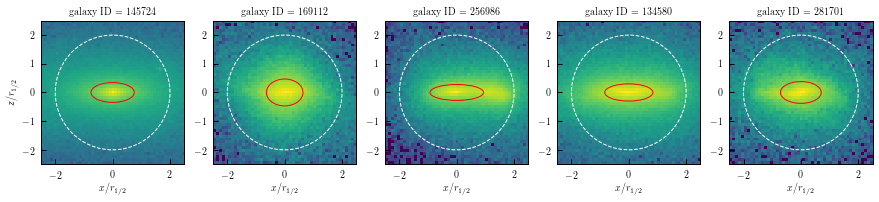

In [158]:
from matplotlib.collections import PatchCollection
from matplotlib.patches import Ellipse

inds = np.random.random_integers(0, high=len(idx), size=5)
inds = idx[inds]

fig, axes = plt.subplots(1,5, figsize=(3.3*5,3.3))

i = inds[0]
ptcl_coords, ptcl_masses = axis_aligned_ptcl_dist(ids[i], Av[i], Bv[i], Cv[i])
im = major_minor_image(ptcl_coords, ptcl_masses)
a, c = t_1['a'][i], t_1['c'][i]

ax=axes[0]
ax.set_title('galaxy ID = ' + str(ids[i]))
fig.subplots_adjust(left=0.2, right=0.9, bottom=0.2, top=0.9)
ax.imshow(im, extent=[-2.5,2.5,-2.5,2.5], origin='lower', vmin=5)
ellipse_0 = Ellipse([0,0], 2*a, 2*c, angle=0, facecolor='none', edgecolor='red')
ax.add_artist(ellipse_0)
ellipse_0 = Ellipse([0,0], 2*2, 2*2, angle=0, facecolor='none', edgecolor='white', linestyle='--')
ax.add_artist(ellipse_0)
ax.set_xlim([-2.5, 2.5])
ax.set_ylim([-2.5, 2.5])
ax.set_xlabel(r'$x/r_{1/2}$')
ax.set_ylabel(r'$z/r_{1/2}$')

i = inds[1]
ptcl_coords, ptcl_masses = axis_aligned_ptcl_dist(ids[i], Av[i], Bv[i], Cv[i])
im = major_minor_image(ptcl_coords, ptcl_masses)
a, c = t_1['a'][i], t_1['c'][i]

ax=axes[1]
ax.set_title('galaxy ID = ' + str(ids[i]))
fig.subplots_adjust(left=0.2, right=0.9, bottom=0.2, top=0.9)
ax.imshow(im, extent=[-2.5,2.5,-2.5,2.5], origin='lower', vmin=5)
ellipse_0 = Ellipse([0,0], 2*a, 2*c, angle=0, facecolor='none', edgecolor='red')
ax.add_artist(ellipse_0)
ellipse_0 = Ellipse([0,0], 2*2, 2*2, angle=0, facecolor='none', edgecolor='white', linestyle='--')
ax.add_artist(ellipse_0)
ax.set_xlim([-2.5, 2.5])
ax.set_ylim([-2.5, 2.5])
ax.set_xlabel(r'$x/r_{1/2}$')
#ax.set_ylabel(r'$z/r_{1/2}$')

i = inds[2]
ptcl_coords, ptcl_masses = axis_aligned_ptcl_dist(ids[i], Av[i], Bv[i], Cv[i])
im = major_minor_image(ptcl_coords, ptcl_masses)
a, c = t_1['a'][i], t_1['c'][i]

ax=axes[2]
ax.set_title('galaxy ID = ' + str(ids[i]))
fig.subplots_adjust(left=0.2, right=0.9, bottom=0.2, top=0.9)
ax.imshow(im, extent=[-2.5,2.5,-2.5,2.5], origin='lower', vmin=5)
ellipse_0 = Ellipse([0,0], 2*a, 2*c, angle=0, facecolor='none', edgecolor='red')
ax.add_artist(ellipse_0)
ellipse_0 = Ellipse([0,0], 2*2, 2*2, angle=0, facecolor='none', edgecolor='white', linestyle='--')
ax.add_artist(ellipse_0)
ax.set_xlim([-2.5, 2.5])
ax.set_ylim([-2.5, 2.5])
ax.set_xlabel(r'$x/r_{1/2}$')
#ax.set_ylabel(r'$z/r_{1/2}$')

i = inds[3]
ptcl_coords, ptcl_masses = axis_aligned_ptcl_dist(ids[i], Av[i], Bv[i], Cv[i])
im = major_minor_image(ptcl_coords, ptcl_masses)
a, c = t_1['a'][i], t_1['c'][i]

ax=axes[3]
ax.set_title('galaxy ID = ' + str(ids[i]))
fig.subplots_adjust(left=0.2, right=0.9, bottom=0.2, top=0.9)
ax.imshow(im, extent=[-2.5,2.5,-2.5,2.5], origin='lower', vmin=5)
ellipse_0 = Ellipse([0,0], 2*a, 2*c, angle=0, facecolor='none', edgecolor='red')
ax.add_artist(ellipse_0)
ellipse_0 = Ellipse([0,0], 2*2, 2*2, angle=0, facecolor='none', edgecolor='white', linestyle='--')
ax.add_artist(ellipse_0)
ax.set_xlim([-2.5, 2.5])
ax.set_ylim([-2.5, 2.5])
ax.set_xlabel(r'$x/r_{1/2}$')
#ax.set_ylabel(r'$z/r_{1/2}$')

i = inds[4]
ptcl_coords, ptcl_masses = axis_aligned_ptcl_dist(ids[i], Av[i], Bv[i], Cv[i])
im = major_minor_image(ptcl_coords, ptcl_masses)
a, c = t_1['a'][i], t_1['c'][i]

ax=axes[4]
ax.set_title('galaxy ID = ' + str(ids[i]))
fig.subplots_adjust(left=0.2, right=0.9, bottom=0.2, top=0.9)
ax.imshow(im, extent=[-2.5,2.5,-2.5,2.5], origin='lower', vmin=5)
ellipse_0 = Ellipse([0,0], 2*a, 2*c, angle=0, facecolor='none', edgecolor='red')
ax.add_artist(ellipse_0)
ellipse_0 = Ellipse([0,0], 2*2, 2*2, angle=0, facecolor='none', edgecolor='white', linestyle='--')
ax.add_artist(ellipse_0)
ax.set_xlim([-2.5, 2.5])
ax.set_ylim([-2.5, 2.5])
ax.set_xlabel(r'$x/r_{1/2}$')
#ax.set_ylabel(r'$z/r_{1/2}$')

plt.show()

fig.savefig('./figures/demo_shapes.png')